In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve,
    precision_score, recall_score, f1_score,accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_predict

<h2 style="text-align: center;">Instituto Superior de Engenharia de Lisboa</h2>  
<h3 style="text-align: center;">Licenciatura em Engenharia Informática e Multimédia</h3>
<p  style="margin-top:20px;text-align: center;">Aprendizagem Automática</p>
<p  style="text-align: center;">Semestre de Inverno 2024/2025</p>
<p  style="text-align: center;">1º Trabalho Prático</p>
<p  style="text-align: center;">Trabalho realizado por: </p>
<div style="margin:auto; display:flex"> 
    <ul style="margin:auto; display:block">
        <li>Alice Fernandes, Aluna Nº 45741</li>
        <li>Guilherme Mendes, Aluno Nº  49718</li>
        <li>Bruno Antunes, Aluno Nº 49755</li>
    </ul>
</div>

# Indíce
1. [Indíce de Figuras](#1---Indíce-de-Figuras)
2. [Introdução](#2---Introdução)
3. [Desenvolvimento](#3---Desenvolvimento)
4. [Conclusão](#4---Conclusão)
5. [Bibliografia](#5---Bibliografia)

# 2 - Introdução

A diabetes é uma doença crónica que afeta milhões de pessoas em todo o mundo, caracterizada por níveis elevados de glicose no sangue. O diagnóstico precoce e preciso desta condição é fundamental para prevenir complicações graves e melhorar a qualidade de vida dos pacientes.

Este trabalho utiliza o **Pima Indians Diabetes Dataset**, criado pelo National Institute of Diabetes and Digestive and Kidney Diseases (EUA), que contém informação sobre 768 mulheres da população indígena Pima, uma população com elevada incidência de diabetes. O dataset inclui 500 mulheres sem diabetes e 268 mulheres com diabetes, sendo cada observação caracterizada por 8 atributos clínicos relevantes: 
- número de gravidezes, 
- concentração de glicose plasmática, 
- pressão arterial diastólica, 
- espessura da dobra cutânea do tríceps, 
- nível sérico de insulina, 
- índice de massa corporal, 
- Diabetes Pedigree Function,
- Idade

O objetivo principal deste trabalho é desenvolver e comparar diferentes modelos de classificação binária capazes de determinar automaticamente se um paciente apresenta diabetes com base nas características fornecidas. Para tal, serão implementados e avaliados três classificadores, incluindo obrigatoriamente o Random Forest, utilizando metodologias adequadas de treino/teste e métricas apropriadas para avaliar o desempenho dos modelos.

Adicionalmente, será investigado o impacto da normalização dos dados no desempenho dos classificadores, analisando se a transformação dos dados para média nula e variância unitária contribui para melhorar a capacidade preditiva dos modelos.

O relatório apresenta uma análise dos resultados obtidos, justificando as escolhas realizadas e discutindo as decisões tomadas ao longo do desenvolvimento do trabalho.


# 3 - Desenvolvimento

Para este trabalho, foram selecionados três classificadores binários para a tarefa de classificação de diabetes. O **Random Forest Classifier** é um classificador obrigatório, baseado em ensemble de árvores de decisão. O **Support Vector Classifier (SVC)** é um algoritmo baseado em máquinas de vetores de suporte com diferentes kernels. A **Logistic Regression** é um modelo linear interpretável que utiliza a função logística.

A calibração dos hiperparâmetros será realizada através de GridSearchCV com validação cruzada (`StratifiedKFold` com 3 folds), garantindo uma exploração sistemática do espaço de hiperparâmetros e uma avaliação robusta dos modelos. Os dados serão divididos em 70% para treino+validação e 30% para teste, utilizando estratificação para manter a proporção de classes em ambos os conjuntos.

Para avaliar o desempenho dos classificadores, serão utilizadas várias métricas, incluindo a Matriz de Confusão, Precision, Recall e F1-Score, bem como as Curvas ROC e Precision-Recall. A avaliação será realizada tanto no conjunto de treino quanto no conjunto de teste para detetar possível overfitting. Será também investigado o impacto da normalização dos dados (transformação para média nula e variância unitária) no desempenho dos classificadores.

## 3.1 - Carregamento e Análise Inicial dos Dados

Nesta secção, procede-se ao carregamento do dataset e à análise exploratória inicial dos dados, incluindo a exploração da estrutura do dataset, distribuição de classes e estatísticas descritivas.

O dataset é um problema de **classificação binária** onde:
- **Classe 0**: Paciente **não** tem diabetes (classe negativa)
- **Classe 1**: Paciente **tem** diabetes (classe positiva)

A variável `y` contém os _labels_ das classes (0 ou 1) para cada amostra, enquanto `X` contém os dados com 8 atributos por cada amostra.


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Carregar dados
data = pickle.load(open("pimaDiabetes.p", "rb"))
X = data['data']
y = data['target']

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"\nNúmero total de amostras: {len(y)}")
print(f"Número de features: {X.shape[1]}")
print("\nClasses do dataset:")
print(f"  - Classe 0 (sem diabetes): {np.sum(y==0)} amostras ({ np.round(np.sum(y==0)/len(y)*100) }%)")
print(f"  - Classe 1 (com diabetes): {np.sum(y==1)} amostras ({ np.round(np.sum(y==1)/len(y)*100) }%)")


Shape de X (features): (768, 8)
Shape de y (target): (768,)

Número total de amostras: 768
Número de features: 8

Classes do dataset:
  - Classe 0 (sem diabetes): 500 amostras (65.0%)
  - Classe 1 (com diabetes): 268 amostras (35.0%)


O dataset apresenta um desequilíbrio entre as classes (65% vs 35%), com m amostras da classe 0 (sem diabetes) do que da classe 1 (com diabetes). Para garantir a mesma proporção os conjuntos de teste e validação, vamos então o usar o parametro _stratify_ para manter a mesma percentagem nos conjuntos. Este parametro é essencial para obter o melhor desempenho dos classificadores, especialmente para detectar amostras com a classe 1, que é a que tem menos representação no conjunto de dados.

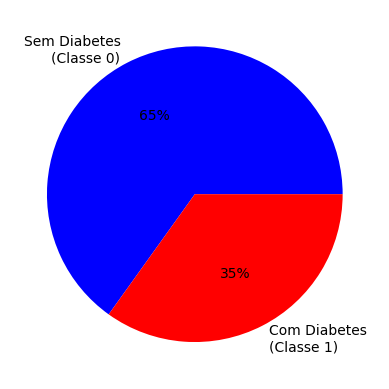

In [3]:
# Dados
classes = ['Sem Diabetes\n(Classe 0)', 'Com Diabetes\n(Classe 1)']
counts = [np.sum(y==0), np.sum(y==1)]
colors = ['blue', 'red']
# Gráfico de pizza
plt.pie(counts, labels=classes, colors=colors, autopct='%1.0f%%')

plt.show()

## 3.2 - Treino de Classificadores

Nesta secção vamos então treinar e avaliar três classificadores binários: `SVC`, `Random Forest Classifier` e `Logistic Regression`. 

Para a divisão dos dados, vamos dividir em 2/3 para treino e validação e 1/3 para teste, com estratificação para manter a proporção de classes em ambos os conjuntos. Esta divisão resulta 512 amostras para treino/validação e 256 amostras para teste, garantindo um conjunto de teste suficientemente grande para uma avaliação robusta.

A calibração dos hiperparâmetros de cada modelo será feita utilizando `GridSearchCV` com validação cruzada estratificada _StratifiedKFold_ com 5 _folds_ (este tipo de K-Fold mantêm a mesma distribuição de classes nos conjuntos). Esta abordagem permite-nos encontrar o melhor conjunto de hiperparametros.

Adicionalmente, para cada classificador, iremos também encontrar o melhor limiar de decisão utilizando validação cruzada. Em vez de usar o limiar de omissão, vamos testar vários limiares (entre 0 e 1) para encontrar aquele que obtém a melhor taxa de verdadeiros positivos, e minimiza os falsos positivos. Para isso, vamos usar a métrica `F1-Score`, que combina as métricas de `precision` e `recall` num único valor. O limiar usado pelo `scikit-learn` nos modelos de classificação binária é 0.5, que pode não ser o mais adequado para os dados que estamos a avaliar.

Para encontrar o limiar de decisão, vamos usar `cross_val_predict`, que treina modelos em cada _fold_ e prevê nas amostras de validação. O limiar encontrado é então aplicado ao conjunto de teste para avaliação final.

### 3.2.1 Métricas de Avaliação

Para avaliar o desempenho dos classificadores, utilizamos várias métricas complementares:

Matriz de Confusão: Tabela que resume as previsões do modelo, mostrando os Verdadeiros Positivos (TP), Verdadeiros Negativos (TN), Falsos Positivos (FP) e Falsos Negativos (FN). Esta matriz permite visualizar onde o modelo está a acertar e a errar, e é útil para identificar se o modelo está a confundir mais frequentemente a classe positiva com a negativa ou vice-versa.

- _Precision_: É uma métrica que ajuda a perceber se o modelo está a acertar corretamente na classificação das classes. É calculada como $\frac{TP}{TP+FP}$. Uma precisão alta indica que quando o modelo prevê diabetes, é provável que esteja correto. Esta métrica é importante quando o custo de um falso positivo é elevado (diagnosticar diabetes quando não existe).

- _Recall_: Esta métrica ajuda a perceber se o modelo consegue detetar todos os casos positivo. É calculada como  $\frac{TP}{TP+FN}$. Um _recall_ alto indica que o modelo consegue detetar a maioria dos casos de diabetes. Esta métrica é importante em problemas de classificação em que falsos negativos podem ter consequencias ao nivel do tratamento(deteção de diabetes quando o paciente não tem diabetes).

- _F1-Score_: É uma métrica que combina as métricas precision e recall. É calculada como $2 \times \frac{precision \times recall }{precision + recall }$.  Esta métrica dá mais importancia a valores baixos, e se a precision e o recall tiverem baixos indica que o nosso modelo não está a dar os melhores resultados.

- _Curva ROC_: Gráfico que mostra a relação entre e o Recall e Falsos Positivos (FP) para vários limiares. A área sob a curva ROC (AUC) varia entre 0 e 1, onde valores próximos de 1 indicam melhor capacidade do modelo discriminar entre classes. Esta curva permite-nos o desempenho de vários limiares, e perceber se o limiar usado é o melhor ou não.

_Curva Precision-Recall_: Gráfico que mostra a relação entre precision e recall para vários limiares. Esta curva foca-se no desempenho da classe positiva (diabetes), ao contrário da curva ROC que nos dá uma visão geral de como os vários limiares se comportam na classificação.

A avaliação será realizada tanto no conjunto de treino quanto no conjunto de teste para evitar o `overfitting` e garantir a capacidade de generalização dos modelos.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3,stratify=y)
cv = StratifiedKFold(n_splits=3) # para o grid search mais tarde

In [16]:
# Funções utilitárias para os classificadores

# Plota duas matrizes de confusão lado a lado (treino e teste).
def plot_confusion_matrices(cm_train, cm_test, title_prefix):
    fig, axes = plt.subplots(1, 2, figsize=(9, 3))
    
    # Treino
    disp_train = ConfusionMatrixDisplay(cm_train)
    disp_train.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title(f'{title_prefix} - Treino')
    
    # Teste
    disp_test = ConfusionMatrixDisplay(cm_test)
    disp_test.plot(ax=axes[1], cmap="Blues", colorbar=False)
    axes[1].set_title(f'{title_prefix} - Teste')
    
    plt.tight_layout()
    plt.show()

# Plota curva ROC (suporta plots fora e dentro de subplots)
def plot_roc_curve(fpr, tpr, roc_auc, threshold_point, model_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    ax.plot(fpr, tpr, color='blue', label='Curva ROC')
    
    ax.scatter(threshold_point[0], threshold_point[1], color='red', label='Limiar',)# Coloca o ponto do limiar a vermelho
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Curva ROC - {model_name}')
    ax.legend()
    ax.axis("scaled")
    ax.grid(True)
    
    if ax is None:
        plt.tight_layout()

def plot_precision_recall_curve(recall_vals, precision_vals, threshold_point, model_name, ax=None):
    ax.plot(recall_vals, precision_vals, color='green', label='Curva Precision-Recall')
    
    ax.scatter(threshold_point[0], threshold_point[1], color='red', label='Limiar',)
  
        
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Curva Precision-Recall - {model_name}')
    ax.legend()
    ax.axis("scaled")
    
    ax.grid(True)
    
    if ax is None:
        plt.tight_layout()
        plt.show()

def find_threshold(model, X_train, y_train, cv, param_grid=None):
    # Obter probabilidades previstas usando validação cruzada
    model.set_params(**param_grid) # aplicar parametros ao modelo
    
    y_train_proba_cv = cross_val_predict(
        model,
        X_train, 
        y_train,
        cv=cv,
        method='predict_proba'
    )[:, 1]
    
    # Testar diferentes limiares (de 0,1, 50 valores)
    threshold_candidates = np.linspace(0, 1, 50)
    f1_scores = []
    
    for threshold in threshold_candidates:
        y_pred_thresh = (y_train_proba_cv >= threshold).astype(int)
        f1_scores.append(f1_score(y_train, y_pred_thresh))
    
    # Encontrar o melhor limiar
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = threshold_candidates[best_threshold_idx]
    best_f1 = f1_scores[best_threshold_idx]
    
    return best_threshold, best_f1, f1_scores

# Plota todos os gráficos num subplot
def plot_threshold_analysis(fpr, tpr, roc_auc, recall_vals, precision_vals, cm_threshold, threshold_point_roc, threshold_point_pr, model_name=''):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    plot_roc_curve(fpr, tpr, roc_auc, threshold_point_roc, model_name, ax=axes[0])
    plot_precision_recall_curve(recall_vals, precision_vals, threshold_point_pr, model_name, ax=axes[1])
    
    # Matriz de confusão com limiar otimizado    
    disp_threshold = ConfusionMatrixDisplay(cm_threshold)    
    disp_threshold.plot(ax=axes[2], cmap='Blues')    
    axes[2].set_title('Confusion Matrix')
    
    plt.tight_layout()
    plt.axis("scaled")
    
    plt.show()


# Adicinei este def por enquanto vou deixar aqui
def plot_CF(cm_1, cm_2, title_prefix1, title_prefix2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    
    # Mostra matriz de confusão 1, com o titlo desejado, title_prefix1
    disp_train = ConfusionMatrixDisplay(cm_1)
    disp_train.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title(f'{title_prefix1}')
    
    # Mostra matriz de confusão 2, com o titlo desejado, title_prefix2
    disp_test = ConfusionMatrixDisplay(cm_2)
    disp_test.plot(ax=axes[1], cmap="Blues", colorbar=False)
    axes[1].set_title(f'{title_prefix2}')
    
    plt.tight_layout()
    plt.show()

### 3.2.1 - SVC 

O primeiro classificador que vamos treinar é o SVC. O SVC, ou Support Vector Classifier, é um classificador baseado no SVM, no sentido em que tenta identificar um hiperplano que separe as classes da forma mais eficaz possível. Este classificador tenta maximizar a margem entre os grupos, ou seja, garantir que a fronteira fica posicionada de modo a aumentar a separação entre os pontos mais próximos de cada classe. 

Isto acaba por tornar o modelo mais estável e menos sensível a pequenas variações nos dados. Quando a separação linear não é viável, recorre-se aos kernels, que permitem mapear os dados para um espaço de maior dimensão onde essa fronteira se torna mais clara e mais fácil de definir.

#### Parametros testados

Para este modelo, escolhemos usar os seguintes parametros. Tentámos balancear os parametros de modo a que a pesquisa de hiperparâmetros não demorasse muito tempo, e colocar várias opções de teste de modo a encontrar um bom conjunto de parametros.

- _kernel_: Algoritmo que define a forma da fronteira de decisão: _linear_ é uma fronteira no formato de uma reta, enquanto _rbf_ e _sigmoid_  permitem fronteiras mais complexas quando os dados não são possiveis de separa com uma fronteira linear
- _C_: Valor de penalização para erros de classificação. Valores baixos tornam o modelo mais tolerante ao erro, valores altos podem fazer com que o modelo entre em sobre-aprendizagem.
- _gamma_: Ajusta o "detalhe" da fronteira de decisão para _kernels_ não lineares. Valores altos permitem fronteiras muito detalhadas, valores baixos fazem com que as fronteiras fiquem mais "suaves" e generalizáveis.

Outros parametros que também testamos foi uma fronteira polinomial (_poly_) e um parametro que tinha em conta a percentagem de cada classe (_class-weight_), mas devido à pesquisa demorar a convergir, ficamos apenas com os 3 parametros descritos acima em detalhe.



Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       333
           1       0.74      0.53      0.61       179

    accuracy                           0.77       512
   macro avg       0.76      0.71      0.73       512
weighted avg       0.77      0.77      0.76       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       167
           1       0.71      0.49      0.58        89

    accuracy                           0.75       256
   macro avg       0.74      0.69      0.70       256
weighted avg       0.75      0.75      0.74       256

Score dos dados de treino: 0.76953125
Score dos dados de teste: 0.75390625


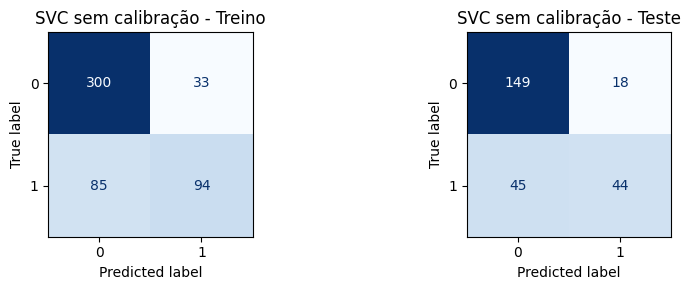

In [6]:
def svc_uncalibrated(X_train, y_train, X_test, y_test ):
    svc = SVC(probability=True, random_state=42, cache_size=1000).fit(X_train, y_train)
    
    # Previsões no conjunto de treino
    y_train_pred_cal = svc.predict(X_train)
    print("\nDesempenho no conjunto de Treino")
    print(classification_report(y_train, y_train_pred_cal))
    cm_train_cal = confusion_matrix(y_train, y_train_pred_cal)

    # Previsões no conjunto de teste
    y_test_pred_cal = svc.predict(X_test)
    print("\nDesempenho no conjunto de Teste")
    print(classification_report(y_test, y_test_pred_cal))
    cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

    print('Score dos dados de treino:', svc.score(X_train, y_train))
    print('Score dos dados de teste:', svc.score(X_test, y_test))

    plot_confusion_matrices(cm_train_cal, cm_test_cal, 'SVC sem calibração')
    return cm_test_cal
    

svc_uncalibrated_cm = svc_uncalibrated(X_train, y_train, X_test, y_test)

In [ ]:
# Definir os hiperparâmetros
# https://stackoverflow.com/questions/72101295/python-gridsearchcv-taking-too-long-to-finish-running

def calibrate_svc(param_grid_svc, X_dataset,y_dataset, cv):
    grid_search_svc = GridSearchCV(
    estimator=SVC(probability=True, random_state=42, cache_size=1000), # aumentar o cache size
        param_grid=param_grid_svc,
        cv=cv,
        n_jobs=-1, #-1 é para usar todos os cores em processamento paralelo
    )

    # Treinar o modelo com GridSearchCV
    grid_search_svc.fit(X_dataset, y_dataset)  
    print(grid_search_svc.best_params_)

    # Usar o melhor modelo encontrado
    return grid_search_svc.best_estimator_, grid_search_svc.best_params_

# Conjunto rápido para correr
param_grid_svc1 = {
    'kernel': ['linear', 'sigmoid'],
}

# Testar multiplos params
# Resultado: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'} - 7m56s
param_grid_svc2 = {
    'C': [0.5, 1, 5,  10, 1000],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001,],
}

# Testar multiplos params
# Resultado: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'} - 11m56s
param_grid_svc3 = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 5, 10, 100],
    'gamma': ['scale', 0.1, 0.01, 0.001],
    'class_weight': [None, 'balanced'],
}

# Resultado: Este não convergiu em tempo util
param_grid_svc4 = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 5, 10,20,50, 100,1000],
    'gamma': ['scale',1, 0.1, 0.01, 0.001],
    'degree': [3], # só usado quando kernel='poly', acima de 3 aumenta risco de overfitting
    # 'class_weight': [None, 'balanced'],
}

# Resultado: {'C': 5, 'gamma': 'scale', 'kernel': 'linear'} - 17m6s
param_grid_svc = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 5, 10,20,50, 100],
    'gamma': ['scale',1, 0.1, 0.01, 0.001],
}

# (Alice) Comentário para não me enganar a correr isto e esperar outros 20m - Retirar antes de entregar
svc_calibrated, svc_best_params = calibrate_svc(param_grid_svc,X_train,y_train, cv)

In [27]:
# Previsões no conjunto de treino
def predict_svc(svc_model, X_train,y_train,X_test,y_test ):
    y_train_pred_cal = svc_model.predict(X_train)
    print("\nDesempenho no conjunto de Treino")
    print(classification_report(y_train, y_train_pred_cal))
    cm_train_cal = confusion_matrix(y_train, y_train_pred_cal)

    # Previsões no conjunto de teste
    y_test_pred_cal = svc_model.predict(X_test)
    print("\nDesempenho no conjunto de Teste")
    print(classification_report(y_test, y_test_pred_cal))
    cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

    # Plotar matrizes de confusão usando a função
    plot_confusion_matrices(cm_train_cal, cm_test_cal, 'SVC com calibração')
    return cm_test_cal
    
    
svc_calibrated_cm = predict_svc(svc_calibrated, X_train,y_train,X_test,y_test)

NameError: name 'svc_calibrated' is not defined

Limiar (validação cruzada): 0.2857142857142857
F1-Score com limiar: 0.6591422121896162
F1-Scores: [0.5180897250361794, 0.521865889212828, 0.5258493353028065, 0.5321375186846039, 0.5429447852760736, 0.5529225908372828, 0.569078947368421, 0.5847750865051903, 0.605072463768116, 0.6214689265536724, 0.63671875, 0.6463414634146342, 0.6582278481012658, 0.6563876651982379, 0.6591422121896162, 0.6527777777777778, 0.6462264150943396, 0.6370370370370371, 0.6354166666666666, 0.6032608695652174, 0.5892351274787535, 0.5789473684210527, 0.5748502994011976, 0.5669781931464174, 0.5659163987138264, 0.5526315789473685, 0.5460750853242321, 0.528169014084507, 0.5035971223021583, 0.4852941176470588, 0.47368421052631576, 0.4357976653696498, 0.42231075697211157, 0.4, 0.39669421487603307, 0.34893617021276596, 0.30701754385964913, 0.28444444444444444, 0.2465753424657534, 0.21495327102803738, 0.1932367149758454, 0.18627450980392157, 0.18719211822660098, 0.1691542288557214, 0.11282051282051282, 0.1041666666666666

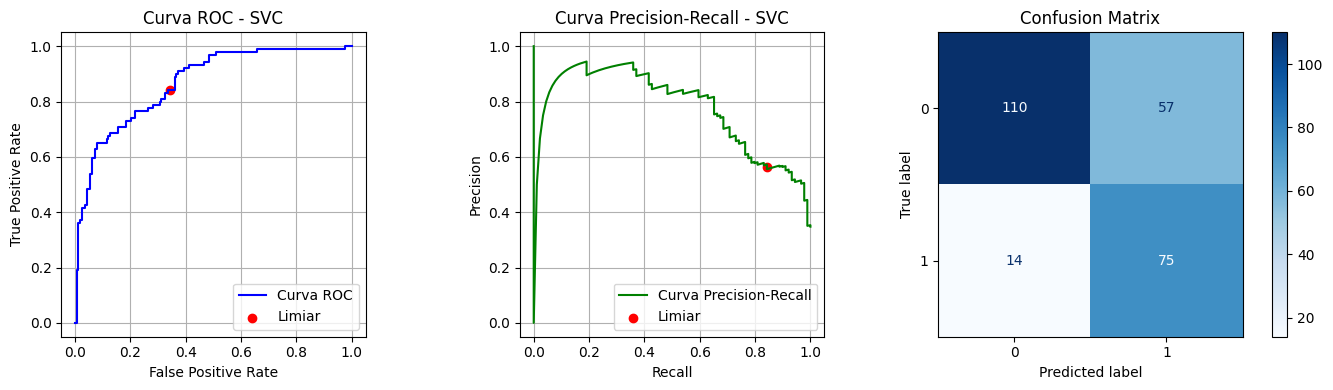

In [ ]:
# Encontrar o limiar ótimo usando validação cruzada
def svc_with_threshold(X_train, y_train,X_test,y_test, cv,svc_best_params, svc_calibrated):
    best_threshold_f1, best_cv_f1, f1_scores = find_threshold(
        SVC(probability=True, random_state=42),
        X_train,
        y_train,
        cv,
        param_grid=svc_best_params
    )

    print(f"Limiar (validação cruzada): {best_threshold_f1}")
    print(f"F1-Score com limiar: {best_cv_f1}")
    print(f"F1-Scores: {f1_scores}")

    # Obter probabilidades no conjunto de teste e aplicar novo limiar apenas á classe positiva
    y_test_proba = svc_calibrated.predict_proba(X_test)
    y_test_proba = y_test_proba[:,1] # Obtem as probabiliades da classe positiva
    y_test_pred_threshold = (y_test_proba >= best_threshold_f1).astype(int)

    print(f"\nDesempenho com limiar ({best_threshold_f1}):") # ISTO ESTÁ REPETIDO

    # Calcular curvas para visualização
    # fp -> false positive
    # tp -> true positive
    fp, tp, thresholds_roc = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fp, tp)
    print("ROC AUC Score:", roc_auc)
    
    print(classification_report(y_test, y_test_pred_threshold))

    precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

    # thresholds_pr - best_threshold_f1 calcula a distancia entre 2 arrays
    # retorna a distancia absoluta, e nós queremos o valor minimo, que seria o limiar mais próximo, com base no f1-score
    # np.argmin retorna o index do array correspondente a valor do array que tem a menor distancia
    idx_closest = np.argmin(np.abs(thresholds_pr - best_threshold_f1))

    cm_test = confusion_matrix(y_test, y_test_pred_threshold)

    # Calcular pontos para os gráficos com limiar calculado
    fp_threshold = cm_test[0, 1] / cm_test[0, :].sum()  # FP / (TN + FP)
    tp_threshold = cm_test[1, 1] / cm_test[1, :].sum()  # TP / (TP + FN)

    plot_threshold_analysis(
        fp, tp, roc_auc,
        recall_vals, precision_vals,
        cm_test,
        (fp_threshold, tp_threshold),
        (recall_vals[idx_closest], precision_vals[idx_closest]),
        'SVC',
    )
    
    return cm_test

svc_calibrated_cm_thres = svc_with_threshold(X_train, y_train,X_test,y_test, cv,svc_best_params, svc_calibrated)

In [17]:
plot_CF(svc_calibrated_cm, svc_calibrated_cm_thres, 'SVC (Calibrado) - Sem Limiar', 'SVC (Calibrado) - Com Limiar')

NameError: name 'svc_calibrated_cm' is not defined

Comparando as duas matrizes acima, SVC calibrado sem limiar e SVC calibrado com limiar, conseguimos observar como o limiar de decisão afeta os resultados da predição.

Sem alterar o limiar, o modelo usa o valor de omissão de 0.5 para decidir se a classe prevista é positiva ou negativa. O resultado disto é  mais conservadora na identificação da classe positiva, o que explica:
- Menos verdadeiros positivos (TP = 50)
- Mais falsos negativos (FN = 39)
- Boa capacidade de identificar negativos (TN = 144)

Ou seja, o modelo privilegia a precisão da classe 0, mas falha uma parte significativa dos casos positivos e acaba por ser um modelo mais conservador

Ao ajustar o limiar, o classificador torna-se mais fica mais sensível à classe dos positivos:
- Aumentam os verdadeiros positivos (TP = 61)
- Diminuem os falsos negativos (FN = 28)
- Mas surgem mais falsos positivos (FP = 31)

### 3.2.2 - Random Forest Classifier (Gui)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar


Vamos agora treinar um outro classificador, obrigatório para este trabalho, o Random Forest Classifier

Score dos dados de treino: 1.0
Score dos dados de teste: 0.82421875


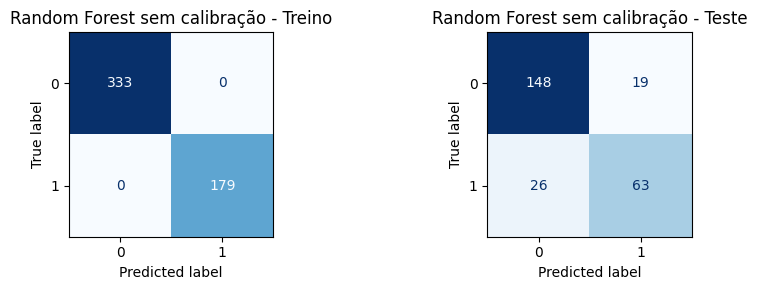

In [ ]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# Previsões no conjunto de treino
y_train_pred_cal = rf.predict(X_train)
# print("\nDesempenho no conjunto de Treino")
# print(classification_report(y_train, y_train_pred_cal))
cm_train_cal = confusion_matrix(y_train, y_train_pred_cal)

# Previsões no conjunto de teste
y_test_pred_cal = rf.predict(X_test)
# print("\nDesempenho no conjunto de Teste")
# print(classification_report(y_test, y_test_pred_cal))
cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

print('Score dos dados de treino:', rf.score(X_train, y_train))
print('Score dos dados de teste:', rf.score(X_test, y_test))

plot_confusion_matrices(cm_train_cal, cm_test_cal, 'Random Forest sem calibração')

Explicar os hiperparametros

In [ ]:

def calibrate_rndForest(param_grid_RndForest, X_dataset,y_dataset, cv):
    grid_search_RndF = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
        param_grid=param_grid_RndForest,
        cv=cv,
        n_jobs=-1, #-1 é para usar todos os cores em processamento paralelo
    )

    # Treinar o modelo com GridSearchCV
    grid_search_RndF.fit(X_dataset, y_dataset)  
    print(grid_search_RndF.best_params_)

    # Usar o melhor modelo encontrado
    return grid_search_RndF.best_estimator_, grid_search_RndF.best_params_

# param_grid_RndForest = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
# }
# param_grid_RndForest = {
#     'n_estimators': [100, 200, 300, 500, 800, 1200, 1500],
#     'max_depth': [None, 5, 10, 15, 20, 30, 40, 60, 80],
# }
# Grid Final
param_grid_RndForest = {
    'n_estimators': [200, 300, 500, 800],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [4, 5, 6, 8, 10],
    'min_samples_split': [2, 3, 4, 5, 8],
    'max_features': ['sqrt', 'log2', None, 0.2, 0.3],
    'bootstrap': [True, False],
    'class_weight': [None],
}

rndforest_calibrated, rndforest_best_params = calibrate_rndForest(param_grid_RndForest,X_train,y_train, cv)


Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       333
           1       0.94      0.89      0.91       179

    accuracy                           0.94       512
   macro avg       0.94      0.93      0.93       512
weighted avg       0.94      0.94      0.94       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       167
           1       0.62      0.54      0.58        89

    accuracy                           0.73       256
   macro avg       0.70      0.68      0.69       256
weighted avg       0.72      0.73      0.72       256

Score dos dados de treino: 0.939453125
Score dos dados de teste: 0.7265625


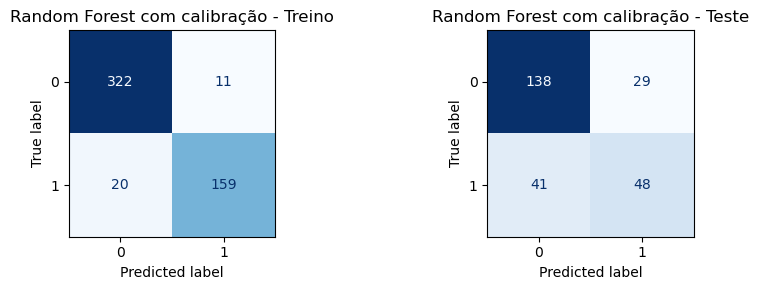

In [ ]:
# Previsões no conjunto de treino
def predict_rndForest(rndforest_model, X_train,y_train,X_test,y_test ):

    # Previsões no conjunto de treino
    y_train_pred_cal = rndforest_model.predict(X_train)
    print("\nDesempenho no conjunto de Treino")
    print(classification_report(y_train, y_train_pred_cal))
    cm_train_cal = confusion_matrix(y_train, y_train_pred_cal)

    # Previsões no conjunto de teste
    y_test_pred_cal = rndforest_model.predict(X_test)
    print("\nDesempenho no conjunto de Teste")
    print(classification_report(y_test, y_test_pred_cal))
    cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

    print('Score dos dados de treino:', rndforest_model.score(X_train, y_train))
    print('Score dos dados de teste:', rndforest_model.score(X_test, y_test))

    # Plotar matrizes de confusão usando a função
    plot_confusion_matrices(cm_train_cal, cm_test_cal, 'Random Forest com calibração')

    return cm_test_cal
    
    
cm_teste_calibracao = predict_rndForest(rndforest_calibrated, X_train,y_train,X_test,y_test)

Explicar Processo, na sintese, e o que pode alterar no resultado do classificador

In [ ]:
# Encontrar o limiar ótimo usando validação cruzada
def rndForest_with_threshold(X_train, y_train,X_test,y_test, cv,rndforest_best_params, rndforest_calibrated):
    best_threshold_f1, best_cv_f1, f1_scores = find_threshold(
        RandomForestClassifier(random_state=42),
        X_train,
        y_train,
        cv,
        param_grid=rndforest_best_params
    )

    print(f"Limiar (validação cruzada): {best_threshold_f1}")
    print(f"F1-Score com limiar: {best_cv_f1}")
    print(f"F1-Scores: {f1_scores}")

    # Obter probabilidades no conjunto de teste e aplicar novo limiar apenas á classe positiva
    y_test_proba = rndforest_calibrated.predict_proba(X_test)
    y_test_proba = y_test_proba[:,1] # Obtem as probabiliades da classe positiva
    y_test_pred_threshold = (y_test_proba >= best_threshold_f1).astype(int)
  
    # Calcular curvas para visualização
    # fp -> false positive
    # tp -> true positive
    fp, tp, thresholds_roc = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fp, tp)
    print("ROC AUC Score:", roc_auc)
    
    print(classification_report(y_test, y_test_pred_threshold))

    precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

    # thresholds_pr - best_threshold_f1 calcula a distancia entre 2 arrays
    # retorna a distancia absoluta, e nós queremos o valor minimo, que seria o limiar mais próximo, com base no f1-score
    # np.argmin retorna o index do array correspondente a valor do array que tem a menor distancia
    idx_closest = np.argmin(np.abs(thresholds_pr - best_threshold_f1))

    cm_test = confusion_matrix(y_test, y_test_pred_threshold)

    # Calcular pontos para os gráficos com limiar otimizado
    fp_threshold = cm_test[0, 1] / cm_test[0, :].sum()  # FP / (TN + FP)
    tp_threshold = cm_test[1, 1] / cm_test[1, :].sum()  # TP / (TP + FN)

    plot_threshold_analysis(
        fp, tp, roc_auc,
        recall_vals, precision_vals,
        cm_test,
        (fp_threshold, tp_threshold),
        (recall_vals[idx_closest], precision_vals[idx_closest]),
        'Random Forest',
    )
    return cm_test

cm_test_limiar = rndForest_with_threshold(X_train, y_train,X_test,y_test, cv,rndforest_best_params, rndforest_calibrated)

NameError: name 'X_train' is not defined

Pequeno texto a comparar as dusa matrizes de confusão

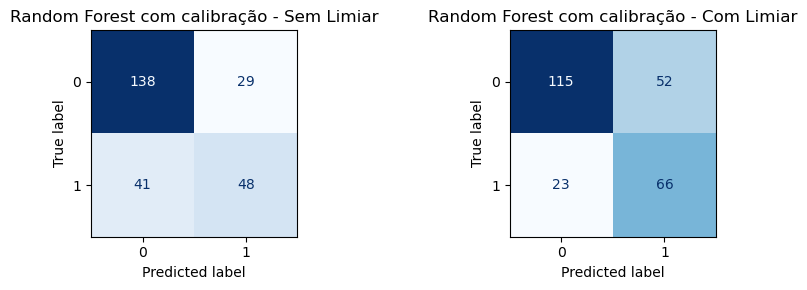

In [ ]:
plot_CF(cm_teste_calibracao, cm_test_limiar, 'Random Forest com calibração - Sem Limiar', 'Random Forest com calibração - Com Limiar')

Meter aqui as árvores de decisão


Melhor árvore no índice 32 com uma acurracy de 0.7539


Text(0.5, 1.0, 'Melhor Árvore de decisão(no índice 32)')

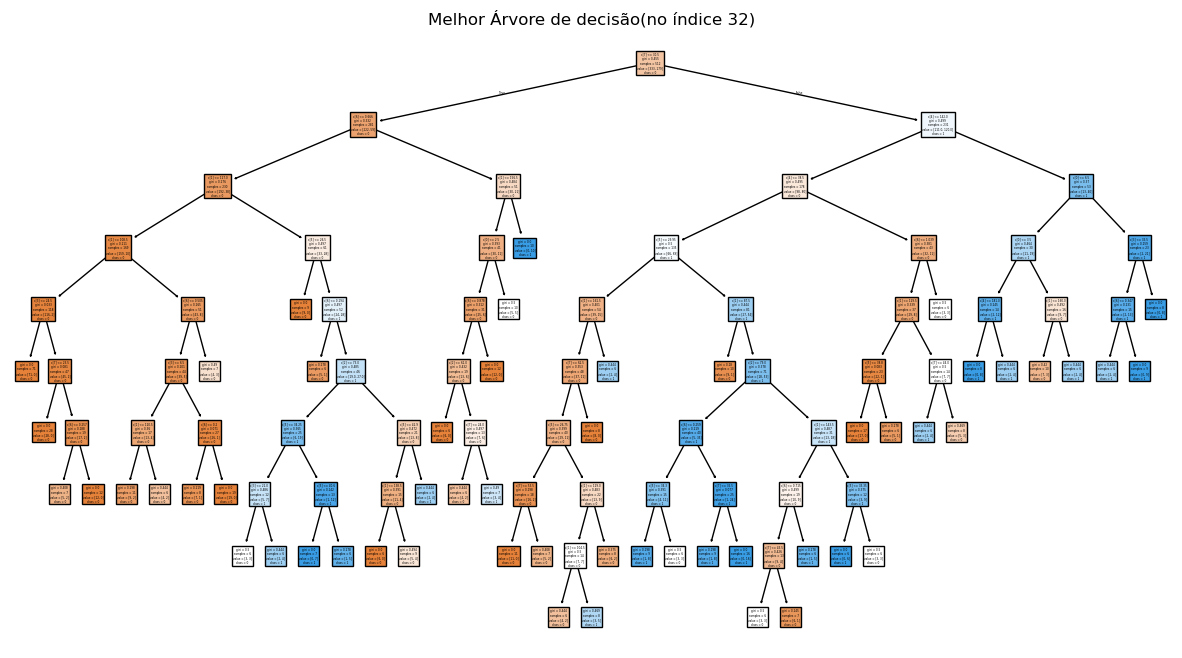

In [ ]:
# Encontrar a melhor árvore de decisão paras os dados de teste

from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

# Avaliar cada árvore individualmente
scores = []
for i, tree in enumerate(rndforest_calibrated.estimators_):
    y_pred = tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores.append(acc)

# Encontrar o índice da melhor árvore
best_idx = np.argmax(scores)
best_tree = rndforest_calibrated.estimators_[best_idx]
print(f"Melhor árvore no índice {best_idx} com uma acurracy de {scores[best_idx]:.4f}")

# Visualizar a melhor árvore
plt.figure(figsize=(15, 8))
plot_tree(
    best_tree,
    filled=True,
    feature_names=X.columns if hasattr(X, "columns") else None,
    class_names=[str(c) for c in np.unique(y)],
    max_depth=None     # coloque None se quiser visualizar a árvore completa
)
plt.title(f"Melhor Árvore de decisão(no índice {best_idx})")

### 3.2.3 - Linear Regression (Bruno)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar


Fitting 3 folds for each of 310 candidates, totalling 930 fits


/home/bruno/Desktop/isel/aa/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bruno/Desktop/isel/aa/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': np.float64(0.46415888336127775), 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}

Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       333
           1       0.72      0.59      0.65       179

    accuracy                           0.78       512
   macro avg       0.76      0.73      0.74       512
weighted avg       0.77      0.78      0.77       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       167
           1       0.67      0.57      0.62        89

    accuracy                           0.75       256
   macro avg       0.73      0.71      0.72       256
weighted avg       0.75      0.75      0.75       256

Score dos dados de treino: 0.77734375
Score dos dados de teste: 0.75390625


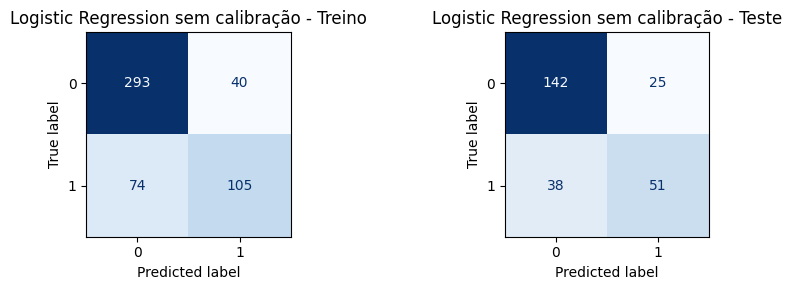


Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       333
           1       0.73      0.59      0.65       179

    accuracy                           0.78       512
   macro avg       0.76      0.74      0.75       512
weighted avg       0.77      0.78      0.77       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       167
           1       0.70      0.57      0.63        89

    accuracy                           0.77       256
   macro avg       0.75      0.72      0.73       256
weighted avg       0.76      0.77      0.76       256

Score dos dados de treino: 0.779296875
Score dos dados de teste: 0.765625


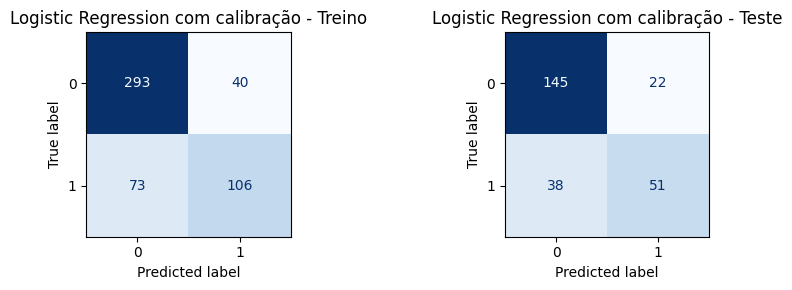

Limiar (validação cruzada): 0.3061224489795918
F1-Score com limiar: 0.6794258373205742
F1-Scores: [0.5180897250361794, 0.5181950509461426, 0.524300441826215, 0.5337331334332833, 0.5519379844961241, 0.5709677419354838, 0.5852842809364549, 0.5968586387434555, 0.6134301270417423, 0.6285714285714286, 0.6299212598425197, 0.6475409836065574, 0.649895178197065, 0.6578947368421053, 0.6712328767123288, 0.6794258373205742, 0.6716791979949874, 0.6683937823834197, 0.6506666666666666, 0.639344262295082, 0.6554621848739496, 0.641399416909621, 0.6347305389221557, 0.6382978723404256, 0.6439628482972136, 0.63125, 0.6242038216560509, 0.6058631921824105, 0.5898305084745763, 0.5674740484429066, 0.5653710247349824, 0.5434782608695652, 0.5313653136531366, 0.47104247104247104, 0.4032258064516129, 0.3514644351464435, 0.3056768558951965, 0.2882882882882883, 0.27522935779816515, 0.2616822429906542, 0.20689655172413793, 0.16243654822335024, 0.12435233160621761, 0.10471204188481675, 0.0851063829787234, 0.07526881

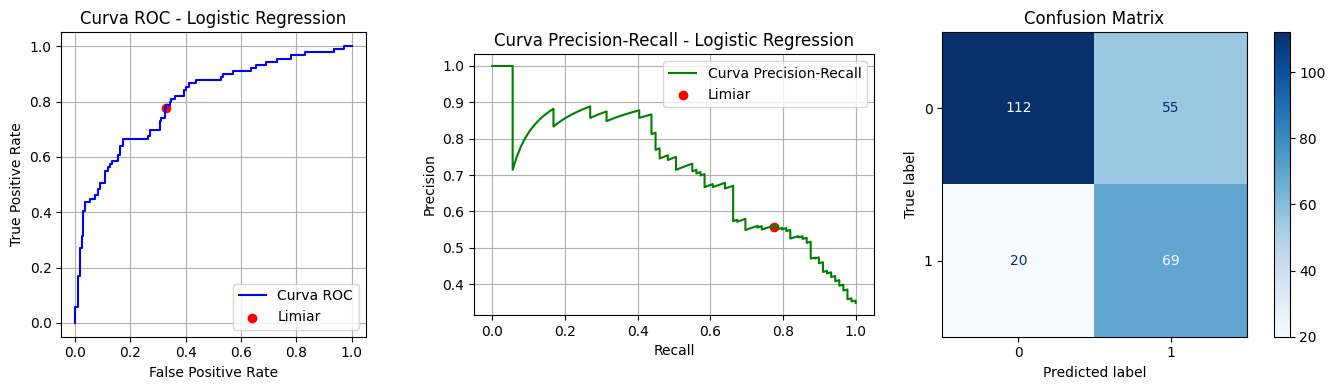

In [ ]:
logistic = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)

def calibrate_logistic(param_grid_logistic, X_dataset,y_dataset, cv):
    grid_search_logistic = GridSearchCV(
    estimator=LogisticRegression(random_state=42), 
        param_grid=param_grid_logistic,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    grid_search_logistic.fit(X_dataset, y_dataset)

    print("Best parameters:", grid_search_logistic.best_params_)
    return grid_search_logistic.best_estimator_, grid_search_logistic.best_params_


param_grid_logistic = [
    {
        'solver': ['lbfgs', 'newton-cg'],
        'penalty': ['l2'],
        'C': np.logspace(-3, 3, 10),
        'max_iter': [200, 500, 2000, 5000]
    },
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-3, 3, 10),
        'max_iter': [200, 500, 2000, 5000]
    },
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-3, 3, 10),
        'max_iter': [5000, 10000, 20000] 
    },
    {
        'solver': ['saga'],
        'penalty': ['elasticnet'],
        'l1_ratio': [0, 0.5, 1.0],  # needed for elasticnet
        'C': np.logspace(-3, 3, 10),
        'max_iter': [5000, 10000, 20000] 
    }
]

logistic_calibrated, logistic_best_params = calibrate_logistic(param_grid_logistic,X_train,y_train, cv)

def predict_logistic(logistic_model, X_train,y_train,X_test,y_test, calibrated=False ):
    
    # Previsões no conjunto de treino
    y_train_pred_cal = logistic_model.predict(X_train)
    print("\nDesempenho no conjunto de Treino")
    print(classification_report(y_train, y_train_pred_cal))
    cm_train_cal = confusion_matrix(y_train, y_train_pred_cal)

    # Previsões no conjunto de teste
    y_test_pred_cal = logistic_model.predict(X_test)
    print("\nDesempenho no conjunto de Teste")
    print(classification_report(y_test, y_test_pred_cal))
    cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

    print('Score dos dados de treino:', logistic_model.score(X_train, y_train))
    print('Score dos dados de teste:', logistic_model.score(X_test, y_test))

    # Plotar matrizes de confusão usando a função
    if(not calibrated):
        plot_confusion_matrices(cm_train_cal, cm_test_cal, 'Logistic Regression sem calibração')
        return
    plot_confusion_matrices(cm_train_cal, cm_test_cal, 'Logistic Regression com calibração')

    return cm_test_cal

cm_test_logistic_no_calib = predict_logistic(logistic, X_train,y_train,X_test,y_test)
cm_teste_logistic = predict_logistic(logistic_calibrated, X_train,y_train,X_test,y_test, True)

# Encontrar o limiar ótimo usando validação cruzada
def logistic_with_threshold(X_train, y_train,X_test,y_test, cv,logistic_best_params, logistic_calibrated):
    best_threshold_f1, best_cv_f1, f1_scores = find_threshold(
        LogisticRegression(random_state=42, max_iter=1000),
        X_train,
        y_train,
        cv,
        param_grid=logistic_best_params
    )

    print(f"Limiar (validação cruzada): {best_threshold_f1}")
    print(f"F1-Score com limiar: {best_cv_f1}")
    print(f"F1-Scores: {f1_scores}")

    # Obter probabilidades no conjunto de teste e aplicar novo limiar apenas á classe positiva
    y_test_proba = logistic_calibrated.predict_proba(X_test)
    y_test_proba = y_test_proba[:,1] # Obtem as probabiliades da classe positiva
    y_test_pred_threshold = (y_test_proba >= best_threshold_f1).astype(int)

    print(f"\nDesempenho com limiar ({best_threshold_f1}):")

    # Calcular curvas para visualização
    # fp -> false positive
    # tp -> true positive
    fp, tp, thresholds_roc = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fp, tp)
    print("ROC AUC Score:", roc_auc)
    
    print(classification_report(y_test, y_test_pred_threshold))

    precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

    # thresholds_pr - best_threshold_f1 calcula a distancia entre 2 arrays
    # retorna a distancia absoluta, e nós queremos o valor minimo, que seria o limiar mais próximo, com base no f1-score
    # np.argmin retorna o index do array correspondente a valor do array que tem a menor distancia
    idx_closest = np.argmin(np.abs(thresholds_pr - best_threshold_f1))

    cm_test = confusion_matrix(y_test, y_test_pred_threshold)

    # Calcular pontos para os gráficos com limiar calculado
    fp_threshold = cm_test[0, 1] / cm_test[0, :].sum()  # FP / (TN + FP)
    tp_threshold = cm_test[1, 1] / cm_test[1, :].sum()  # TP / (TP + FN)

    plot_threshold_analysis(
        fp, tp, roc_auc,
        recall_vals, precision_vals,
        cm_test,
        (fp_threshold, tp_threshold),
        (recall_vals[idx_closest], precision_vals[idx_closest]),
        'Logistic Regression',
    )
    return cm_test  

logistic_calibrated_cm_thres = logistic_with_threshold(X_train, y_train,X_test,y_test, cv,logistic_best_params, logistic_calibrated)

### 3.2.4 - Análise dos classificadores
- Pegar nos dados dos 3 classificadores acima, e juntar num subplot de 3 figuras
    - Printar confusion matrix dos 3 (com os dados de teste)
    - Printar as curvas roc dos 3 ao mesmo tempo

## 3.3 - Pré-processamento

Antes de treinar os modelos com normalização, é importante analisar as características dos dados originais. Diferentes algoritmos de machine learning têm sensibilidades distintas à escala dos dados:

- **SVC e Logistic Regression**: São algoritmos baseados em distâncias e gradientes, muito sensíveis à escala das features. Quando as features têm escalas muito diferentes, as features com valores maiores podem dominar o cálculo das distâncias e influenciar desproporcionalmente o modelo.

- **Random Forest**: É baseado em árvores de decisão que fazem divisões baseadas em thresholds, sendo naturalmente invariante à escala dos dados. A normalização geralmente não afeta significativamente o seu desempenho.

A normalização usando **StandardScaler** transforma os dados para terem média 0 e variância 1, colocando todas as features na mesma escala. Isto permite que algoritmos sensíveis à escala possam aprender de forma mais equilibrada a partir de todas as features.

### 3.3.1 - Análise dos Dados Originais

Vamos começar por analisar as estatísticas dos dados originais para perceber se existe necessidade de normalização.

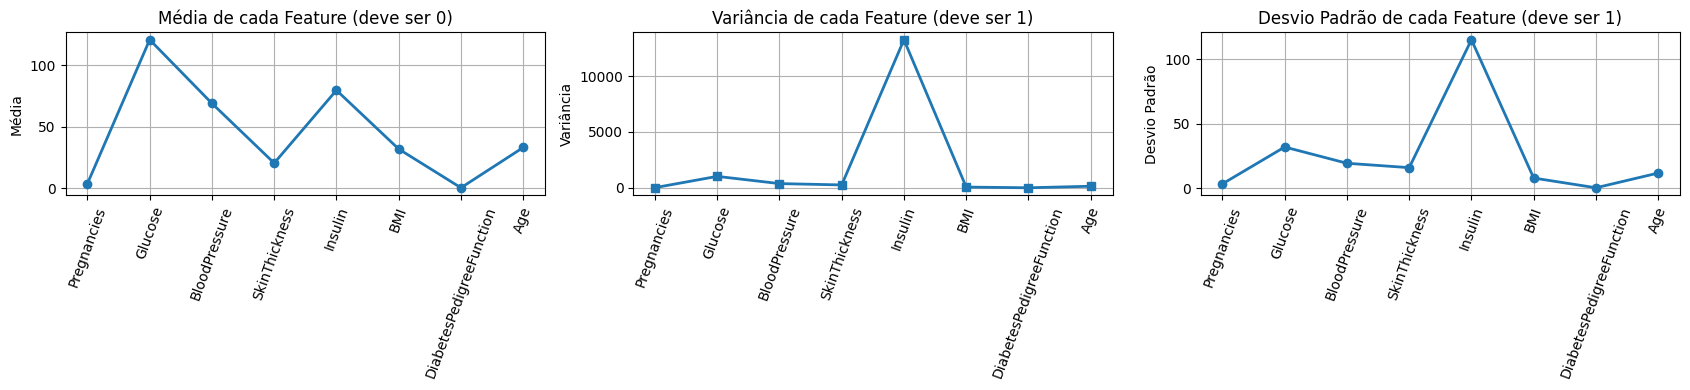

In [ ]:
feature_names = [
    'Pregnancies',
    'Glucose', 
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI',
    'DiabetesPedigreeFunction',
    'Age'
]

def print_stats(X_norm):
    # Calcular estatísticas dos dados normalizados (arrendondado para tirar os floats)
    means_norm = [np.round(np.mean(X_norm[:, i]),2) for i in range(len(feature_names))]
    variances_norm = [np.round(np.var(X_norm[:, i]),2) for i in range(len(feature_names))]
    stds_norm = [np.round(np.std(X_norm[:, i]),2) for i in range(len(feature_names))]
    fig, axes = plt.subplots(1, 3, figsize=(17, 4))

    # Média (deve ser ~0)
    axes[0].plot(feature_names, means_norm, marker='o', linewidth=2,)
    axes[0].set_ylabel('Média')
    axes[0].set_title('Média de cada Feature (deve ser 0)')
    axes[0].grid(True,)
    axes[0].tick_params(axis='x', rotation=70)

    # Variância (deve ser ~1)
    axes[1].plot(feature_names, variances_norm, marker='s', linewidth=2,)
    axes[1].set_ylabel('Variância')
    axes[1].set_title('Variância de cada Feature (deve ser 1)')
    axes[1].grid(True,)
    axes[1].tick_params(axis='x', rotation=70)

    # Desvio Padrão (deve ser ~1)
    axes[2].plot(feature_names, stds_norm, marker='o', linewidth=2)
    axes[2].set_ylabel('Desvio Padrão')
    axes[2].set_title('Desvio Padrão de cada Feature (deve ser 1)')
    axes[2].grid(True,)
    axes[2].tick_params(axis='x', rotation=70)

    plt.tight_layout()
    plt.show()
    
print_stats(X)

Como podemos observar nos resultados acima, as features apresentam escalas muito diferentes e valores em intervalos muito grandes.
Estas diferenças e escala podem afetar de forma negativa os algoritmos _SVC_ e _Logistic Regression_, onde _features_ com valores maiores (como Insulin ou Glucose) podem ter maior impacto no modelo, enquanto _features_ com valores pequenos (como DiabetesPedigreeFunction) podem ter pouco impacto no modelo.

### 3.3.2 - Normalização com StandardScaler

Vamos agora aplicar o **StandardScaler** para transformar os dados. Esta técnica transforma cada feature de modo a que:

$$X_{normalizado} = \frac{X - \mu}{\sigma}$$

Onde:
- $\mu$ é a média da feature
- $\sigma$ é o desvio padrão da feature

Após esta transformação, todas as features terão **média 0** e **variância 1**.

In [8]:
# Normalizar os dados
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Dividir os dados normalizados
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=1/3, stratify=y)

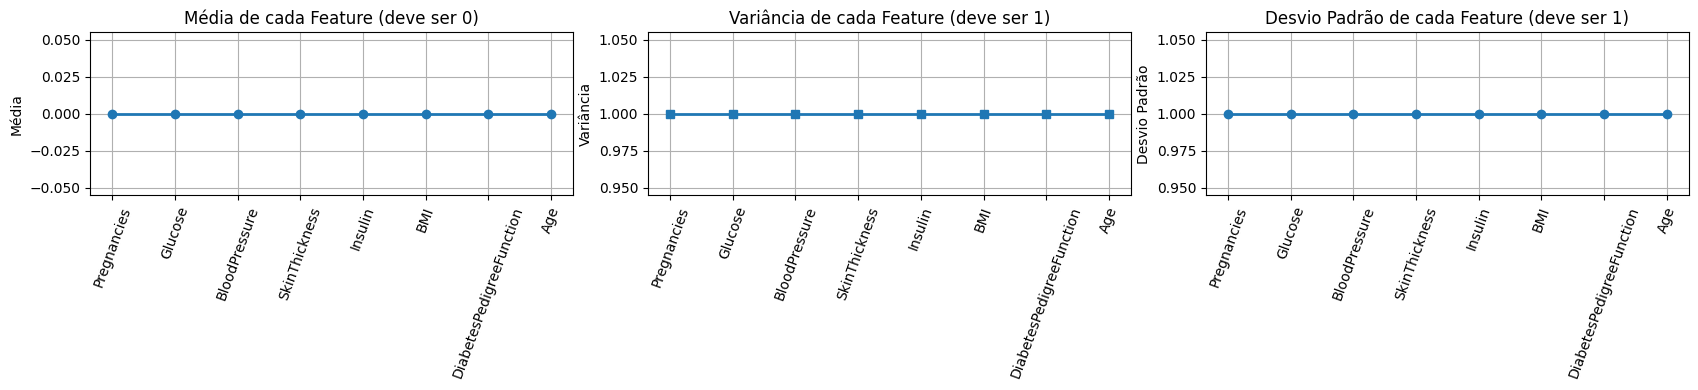

In [9]:
print_stats(X_norm)

Após a normalização, podemos ver que todas as _features_ têm média 0 e variância 1 (valores arredondados no gráfico). Esta transformação permite algoritmos como SVC e Logistic Regression, possam:
- Aprender de forma mais equilibrada de todas as features
- Convergir mais rapidamente durante o treino
- Melhorar o desempenho dos classificadores

Nas próximas secções, vamos treinar os mesmos classificadores com os dados normalizados e comparar os resultados com os modelos treinados com dados originais.

### 3.3.2 - Treino com Pré-Processamento - SVC

Aplicando o mesmo processo que no capítulo 3.2.1, temos o seguinte

In [13]:
svc_calibrated_scaled, svc_best_params_scaled = calibrate_svc(param_grid_svc, X_train_norm, y_train_norm, cv)

{'C': 20, 'gamma': 0.001, 'kernel': 'sigmoid'}



Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       333
           1       0.77      0.55      0.64       179

    accuracy                           0.79       512
   macro avg       0.78      0.73      0.74       512
weighted avg       0.78      0.79      0.77       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       167
           1       0.69      0.52      0.59        89

    accuracy                           0.75       256
   macro avg       0.73      0.70      0.70       256
weighted avg       0.74      0.75      0.74       256



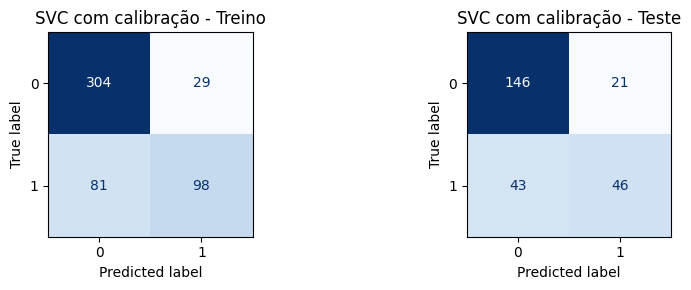

array([[146,  21],
       [ 43,  46]])

In [14]:
# Previsões no conjunto de treino
predict_svc(svc_calibrated_scaled, X_train_norm, y_train_norm, X_test_norm, y_test_norm)

In [ ]:
svc_calibrated_cm_thres_scaled = svc_with_threshold(X_train_norm, y_train_norm, X_test_norm, y_test_norm, cv, svc_best_params_scaled, svc_calibrated_scaled)

NameError: name 'svc_with_threshold' is not defined

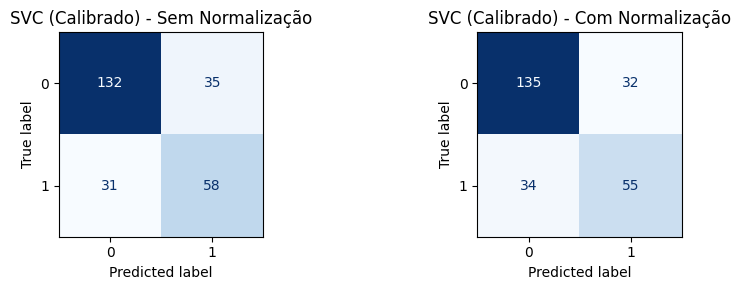

In [ ]:
plot_CF(svc_calibrated_cm_thres,svc_calibrated_cm_thres_scaled, 'SVC (Calibrado) - Sem Normalização', 'SVC (Calibrado) - Com Normalização')

Comparando as duas matrizes acima, SVC calibrado sem normalização e SVC calibrado com normalização, conseguimos observar como a escala dos dados afeta a forma como o classificador define a fronteira de decisão.

Sem aplicar normalização, o modelo trabalha com a escala original das variáveis, o que pode fazer com que  que alguns atributos tenham mais importancia relativamente a outros, devido aos valores altos. Neste cenário, o classificador apresenta:
- Menos verdadeiros negativos (TN = 132)
- Mais falsos positivos (FP = 35)
- E58 verdadeiros positivos, com de 31 falsos negativos

Ou seja, o SVC sem normalização tende a ser mais permissivo na classe 1, resultando em mais falsos positivos, muito provavelmente porque algumas variáveis acabam por ter mais influência na definição da fronteira que outras.

Quando aplicamos normalização, todas as variáveis passam a na mesma escala, minimizando o impacto atributos com maior valor. Neste caso, o modelo torna-se ligeiramente mais conservador e estável:
- Aumentam os verdadeiros negativos (TN = 135)
- Diminuem os falsos positivos (FP = 32)
- Temos também uma redução nos verdadeiros positivos (TP = 55) e um aumento nos falsos negativos (FN = 34)

Deste modo, o SVC com normalização passa a controlar melhor a fronteira associada à classe 0, embora que seja menos sensivel à classe 1.

### 3.3.3 - Treino com Pré-Processamento - Logistic Regression (Bruno)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar


Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       333
           1       0.74      0.58      0.65       179

    accuracy                           0.78       512
   macro avg       0.77      0.73      0.74       512
weighted avg       0.78      0.78      0.77       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       167
           1       0.70      0.53      0.60        89

    accuracy                           0.76       256
   macro avg       0.74      0.70      0.71       256
weighted avg       0.75      0.76      0.75       256

Score dos dados de treino: 0.78125
Score dos dados de teste: 0.7578125


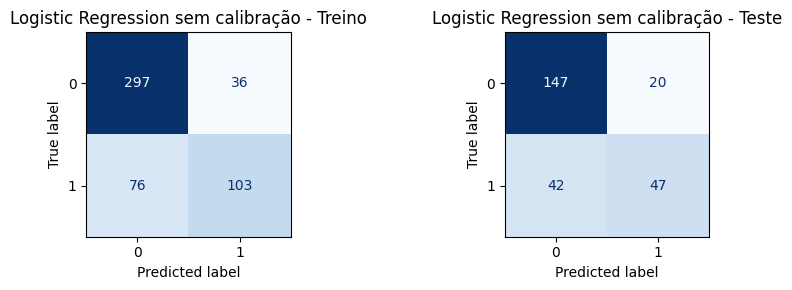

Fitting 3 folds for each of 310 candidates, totalling 930 fits
Best parameters: {'C': np.float64(0.1), 'l1_ratio': 0.5, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga'}

Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       333
           1       0.76      0.54      0.63       179

    accuracy                           0.78       512
   macro avg       0.77      0.72      0.74       512
weighted avg       0.78      0.78      0.77       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       167
           1       0.72      0.52      0.60        89

    accuracy                           0.76       256
   macro avg       0.75      0.70      0.72       256
weighted avg       0.76      0.76      0.75       256

Score dos dados de treino: 0.779296875
Score dos dados de teste: 0.76171875


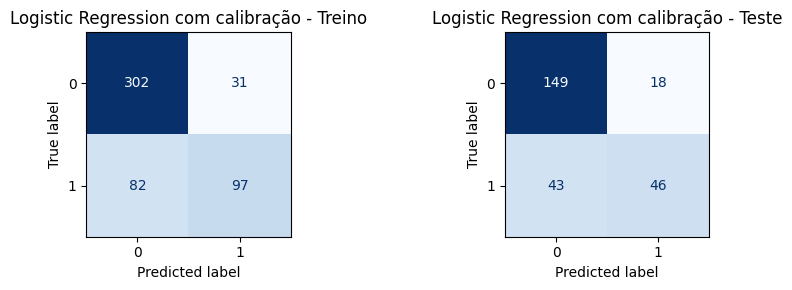

Limiar (validação cruzada): 0.32653061224489793
F1-Score com limiar: 0.6732186732186732
F1-Scores: [0.5180897250361794, 0.5181950509461426, 0.5250737463126843, 0.5347432024169184, 0.5457364341085271, 0.5681818181818182, 0.5852842809364549, 0.6126760563380281, 0.6279491833030852, 0.6452830188679245, 0.6521739130434783, 0.6612244897959184, 0.6722689075630253, 0.6725274725274726, 0.6651480637813212, 0.6619047619047619, 0.6732186732186732, 0.6666666666666666, 0.6666666666666666, 0.6721763085399449, 0.6475644699140402, 0.6392961876832844, 0.6402439024390244, 0.6292834890965732, 0.6449511400651465, 0.6333333333333333, 0.6283783783783784, 0.6041666666666666, 0.5765124555160143, 0.5683453237410072, 0.5579710144927537, 0.5387453874538746, 0.5263157894736842, 0.47808764940239046, 0.4297520661157025, 0.39148936170212767, 0.3739130434782609, 0.35555555555555557, 0.30414746543778803, 0.27358490566037735, 0.25, 0.20689655172413793, 0.12371134020618557, 0.08421052631578947, 0.053475935828877004, 0.03

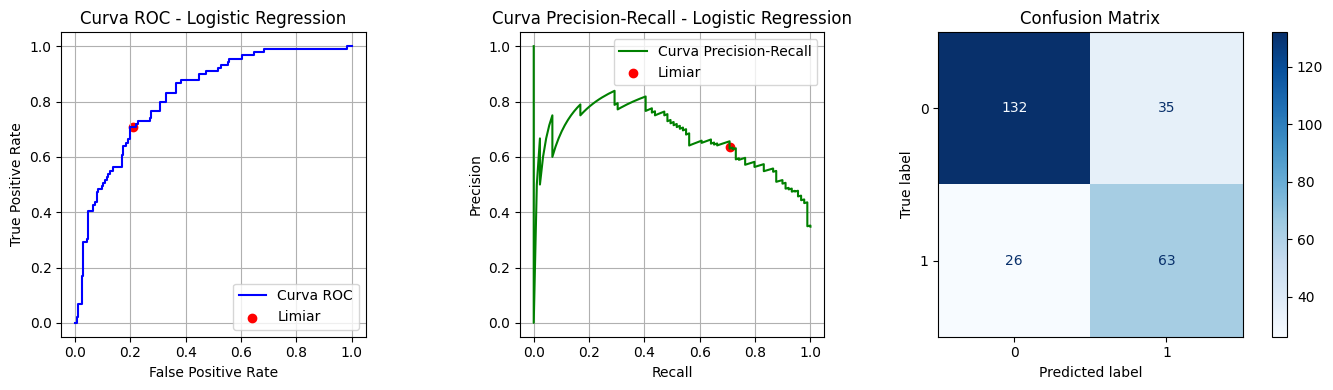

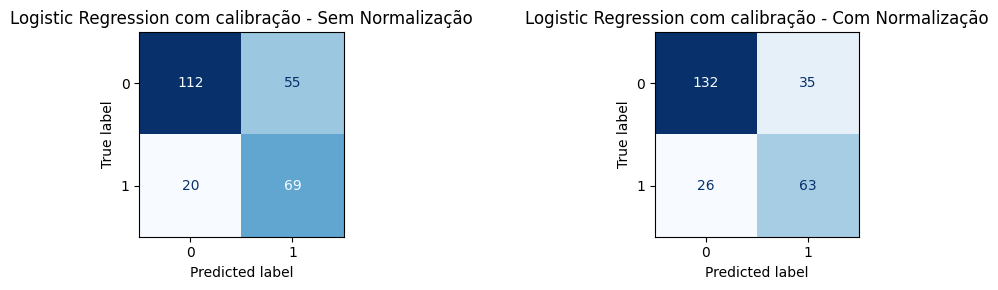

In [18]:
# create logistic regression with normalizaton
log_reg_norm = LogisticRegression(random_state=42, max_iter=1000).fit(X_train_norm, y_train_norm)

# Previsões no conjunto de treino
y_train_pred_log = log_reg_norm.predict(X_train_norm)
print("\nDesempenho no conjunto de Treino")
print(classification_report(y_train_norm, y_train_pred_log))
cm_train_log = confusion_matrix(y_train_norm, y_train_pred_log)

# Previsões no conjunto de teste
y_test_pred_log = log_reg_norm.predict(X_test_norm)
print("\nDesempenho no conjunto de Teste")
print(classification_report(y_test_norm, y_test_pred_log))
cm_test_log = confusion_matrix(y_test_norm, y_test_pred_log)
print('Score dos dados de treino:', log_reg_norm.score(X_train_norm, y_train_norm))
print('Score dos dados de teste:', log_reg_norm.score(X_test_norm, y_test_norm))

plot_confusion_matrices(cm_train_log, cm_test_log, 'Logistic Regression sem calibração')

# treinar modelo com grid search
logistic_calibrated_scaled, logistic_best_params_scaled = calibrate_logistic(param_grid_logistic, X_train_norm, y_train_norm, cv)
# Previsões no conjunto de treino
predict_logistic(logistic_calibrated_scaled, X_train_norm, y_train_norm, X_test_norm, y_test_norm, True)
logistic_calibrated_cm_thres_scaled = logistic_with_threshold(X_train_norm, y_train_norm, X_test_norm, y_test_norm, cv, logistic_best_params_scaled, logistic_calibrated_scaled)

# plot comparativo
plot_CF(logistic_calibrated_cm_thres,logistic_calibrated_cm_thres_scaled, 'Logistic Regression com calibração - Sem Normalização', 'Logistic Regression com calibração - Com Normalização')

### 3.3.4 - Treino com Pré-Processamento - Random Forest (Gui)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar

In [ ]:
rndforest_calibrated_scaled, rndForest_best_params_scaled = calibrate_rndForest(param_grid_RndForest, X_train_norm, y_train_norm, cv)

In [ ]:
# Previsões no conjunto de treino
predict_rndForest(rndforest_calibrated_scaled, X_train_norm, y_train_norm, X_test_norm, y_test_norm)

In [ ]:
rndForest_with_threshold(X_train_norm, y_train_norm, X_test_norm, y_test_norm, cv, rndForest_best_params_scaled, rndforest_calibrated_scaled)

### 3.3.5 - Análise dos classificadores
- Pegar nos dados dos 3 classificadores acima, e juntar num subplot de 3 figuras
    - Printar confusion matrix
    - Printar as curvas roc dos 3 ao mesmo tempo


# 4 - Conclusões




# 5 - Bibliografia

- https://mariofilho.com/precisao-recall-e-f1-score-em-machine-learning/ 
- https://studyeasy.org/pt/course-articles/machine-leaning-articles-pt/auc-and-pr-curve-background-pt/#binary-classification-a-primer
- https://www.geeksforgeeks.org/machine-learning/how-to-choose-the-best-kernel-function-for-svms/